決定木
--------------------
- クラス分類と回帰タスクに広く用いられる
- Yes/Noで答えられる質問で構成された階層的な木構造で学習


In [1]:
import mglearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

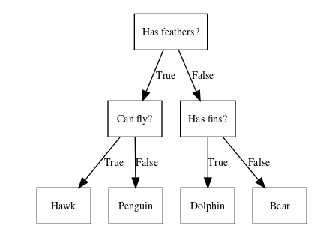

In [2]:
mglearn.plots.plot_animal_tree()

### 決定木の構築
- 決定木における学習は、正解に最も速くたどり着けるような一連のYes/No型の質問の学習を意味する
    - 機械学習においてこれらの質問は「テスト」と呼ばれる
- 通常データの特徴量は2次元データセットの用に連続値となっている
    - 連続値に対するテストは「特徴量iは値αよりも大きいか?」という形をとる
- アルゴリズムは全ての可能なテストの中から、目的変数に対して最も情報量の多いものを選ぶ 
- データの再帰分割は、対象の領域(決定木の葉)に一つの対象値(1クラスもしくは1つの回帰値)しか含まれなくなるまで繰り返す
    - 一つの対象値のデータポイントしかふくまないような決定木の葉を「純粋(pure)」と呼ぶ

### 決定木の複雑さの制御
- 葉が純粋になるまで分割を続けるとモデルは複雑になりすぎ、訓練データに対して大幅に過剰適合してしまう
- 過剰適合を防ぐには2つの戦略がある

#### 1.事前枝刈り(pre-pruning)
- 構築過程で木の生成を早めに止める
- 木の深さを制限する、葉の最大値を制限する、分割する際にその中に含まれている点の最小数を決めておくなどの方法がある

#### 2.事後枝刈り(post-pruning) ※ ただの枝刈りとも呼ばれる
- 一度木を構築してから、情報量の少ないノードを削除する


### scikit-learnの決定木
- scikit-learnでは決定木は「DecisionTreeRegressor」クラスと「DecisionTreeClassifier」クラスがある
- scikit-learnには事前枝刈りしか実装されていない

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_train, X_test,  y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


- 決定木の深さに制約を与えないと決定木はいくらでも深く、複雑になる。したがって、枝刈りされていない木は過剰適合になりやすく、新しいデータに対する汎化性能が低い傾向にある

#### 深さに制限をつける

In [4]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.951


- max_depth=4とし、木の深さに制限を掛ける
- 訓練セットに対する精度は下がるがテストデータに対する精度は向上する

### 決定木の解析
- treeモジュールのexport_graphviz関数を使うことで木を可視化できる
    - 正しくはexport_graphvizで「.dot」ファイルを書き出すことができる

In [5]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"],
               feature_names=cancer.feature_names, impurity=False, filled=True)

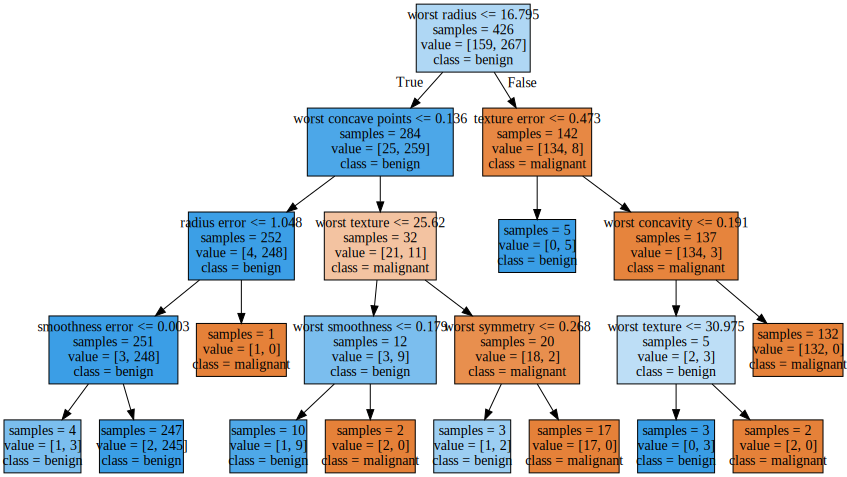

In [6]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### 決定木の特徴量の重要性
- 決定木全体をみるのは大変なので、決定木から導出できる、決定木の挙動を要約する特性値をみてみる
- 要約に最もよく使われるのは、「特徴量の重要度(feature importance)」と呼ばれる
    - 決定木が行う判断にとって、個々の特徴量がどの程度重要なのかを示す割合
    - それぞれの特徴量に対する0と1の間の数
        - 0 => 「全くつかわれていない」
        - 1 => 「完全にターゲットを予想できる」

#### 特徴量の重要度をログに表示

In [7]:
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


#### 重要度をグラフに表示

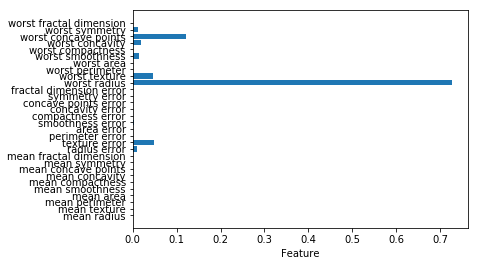

In [8]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.xlabel("Feature")
plot_feature_importances_cancer(tree)

- 最初の分岐に用いた特徴量「worst radius」が群を抜いて重要だということがわかる
    - 最初のレベルで2つのクラスがかなりきれいに分離できているという観察結果と一致
- しかし、ある特徴量の重要度(feature_importance_)の値が低いからといって、その特徴量の持つ情報が少ないとは限らない
    - 単純にその決定木で採用されなかっただけ
    - 特徴量の重要度はサンプルが良性か悪性かを判断する上で「worst radius」が重要だということを教えてくれているだけ

Feature importances: [0. 1.]


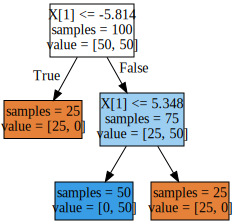

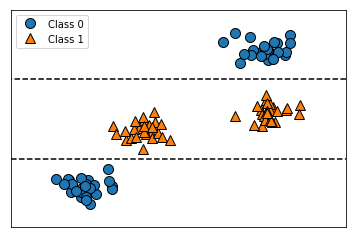

In [9]:
from IPython.display import display
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)

- 上記は2つの特徴量を持つ２つのクラスからなるデータセットを示している
- ここでは全ての情報はX[1]にあるX[0]は使われていない
- しかし、「X[1] の値が大きいとクラス0になり、小さいとクラス1となる」というわけではない

### 回帰決定木(DecisionTreeRegressor)
- 使い方はほとんど分類と同じ
- 注意点として決定木によるモデルを回帰に使う際は「外挿(extrapolate)」ができない
    - つまり訓練データのレンジの外側に対して予測ができない

#### 例: 計算機のメモリ価格の履歴データ

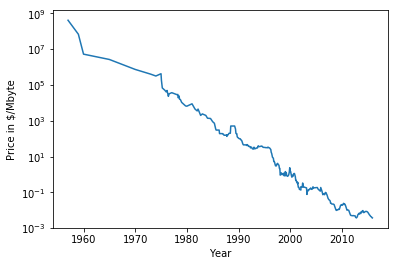

In [10]:
import os
ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "ram_price.csv"))
plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte")

- y軸は対数スケールになっている

#### 2000年以降の価格の予想

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
# 過去のデータを用いて2000年以降の価格を予想する

data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# 日付に基いて価格を予想
X_train = data_train.date[:, np.newaxis]
# データとターゲットの関係を単純にするために対数変換
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# 全ての価格を予想
X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

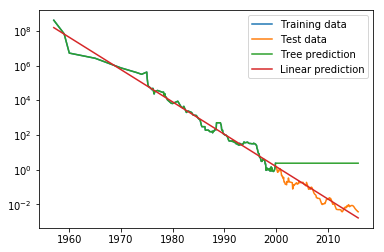

In [12]:
plt.semilogy(data_train.date, data_train.price, label="Training data")
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, price_tree, label="Tree prediction")
plt.semilogy(ram_prices.date, price_lr, label="Linear prediction")
plt.legend()

- 線形モデルはデータを直線で近似する
    - 細かい変異は取りこぼすが2000年以降のテストデータにもよい予想をしている
- 決定木は、訓練データに対して完璧な予想をする
    - しかし、モデルがデータをもっていない2000年以降は正しい予想を行うことができない(最後の点を返すだけ)
    - 決定木は訓練データにない領域「外挿(extrapolate)」ができない

### 決定木を使うメリット
- 結果のモデルが容易に可視化可能で理解しやすい
- データのスケールに対して完全に不変である
    - ここの特徴量は「独立に処理され」、データの分割はスケールに依存しないため正規化や標準化をする必要がない
    
### 決定木を使うメリット
- 事前枝刈りを行ったとしても過剰適合しやすく、汎化性能が低い

決定木のアンサンブル法
----------------

- アンサンブル法(Ensembles)とは複数の機械学習モデルを組み合わせることで、より強力なモデルを構築する手法

### ランダムフォレスト
- 少しずつことなる決定木をたくさん集めたもの
- 「個々の決定木は比較的うまく予測できているが、一部のデータに対して過剰適合してしまっている」という考えに基づいている
- それぞれ異なった方向に過剰適合した決定木をたくさん作れば、その結果の平均をとることで過剰適合の度合いを減らすことができる
- 個々の決定木がお互いにことなるように、決定木の構築過程で乱数を導入している

#### ランダムフォレストの構築
- 1.構築する決定木の数を決める
    - RandomForestRegressor, RandomForestClassifierのn_estimatorsパラメータ
- 2.データからブートストラップサンプリング(bootstrap sample)を行う
    - n_samples個のデータポイントから、交換あり(復元抽出)でn_sample回呼び出す手法
    - もとのデータセットを同じ大きさだが、データの一部(だいたい3分の1)が欠け一部が何度か現れるデータセットが得られる
- 3.データセットを用いて決定木を作る
    - 個々のノードで最適なテストを選ぶのではなく、特徴量のサブセットをランダムに選び、その特徴量を使うものの中から最適なテストを選ぶ
    - 特徴量サブセットの大きさは、パラメータ「max_features」で制御できる
    - この特徴量のサブセットの選択は、ここのノードで独立に繰り返し行われる。これにより決定木の個々のノードが異なる特徴量のサブセットを使って決定を行うようになる
    
---

- ブートストラップサンプリングにより、ランダムフォレストの中の個々の決定木が少しずつ違うデータセットに対して構築される。さらにこのノードでの特徴量選択によって、それぞれの決定木は異なる特徴量のサブセットに対して分割を行うことになる。
- これらの機構が組み合わされることで、ランダムフォレストの中の個々の決定木が異なるものになる

### 重要なポイント
- 重要なパラメータは「max_features」
- max_featuresをn_featuresに設定すると、それぞれの分岐でデータセット中の全ての特徴量をみることになり、特徴量選択時の乱数性はなくなる(ブートストラップサンプリングによる乱数性はのこる)
- max_featuresを1にすると、分岐時につかう特徴量選択に全く選択肢がないことになり、ランダムに選ばれたある特徴量にたいしてスレッショルド※を探すだけになる
    - ※しきい値
- したがって、max_featuresを大きくすると、ランダムフォレスト中の決定木が似たようなものになり、最も識別性が高い特徴量を使うため、訓練データに容易に適合できる
- max_featuresを小さくするとランダムフォレスト中の決定木は相互に大幅にことなるものとなるが、それぞれの決定木をかなり深く作らないとデータに適合できない

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

In [14]:
X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

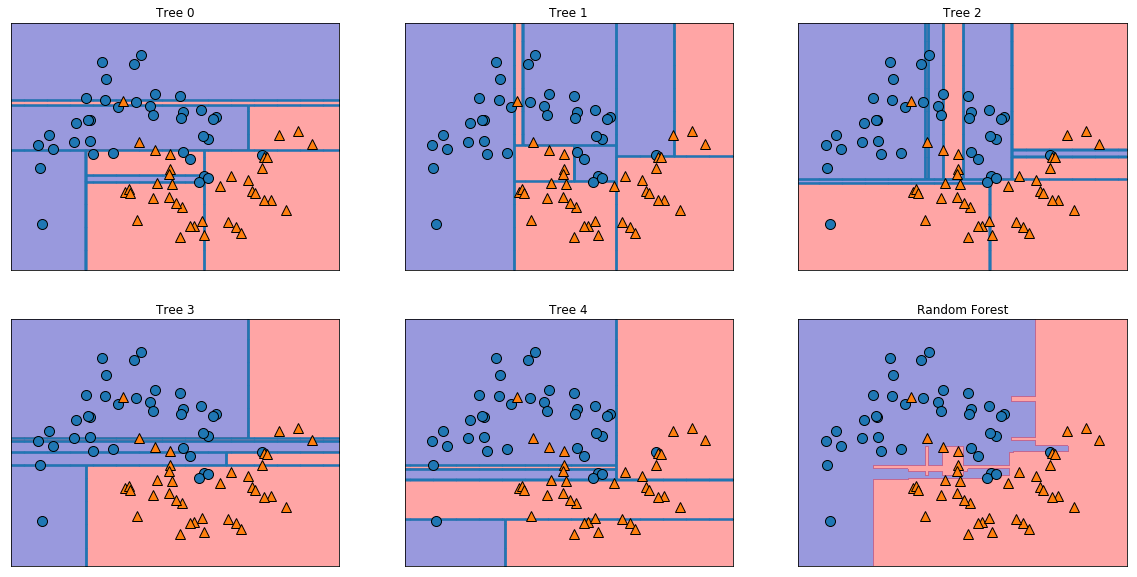

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)

mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

- 5つの決定木が学習した決定境界は明らかに相互にことなる
- それぞれの決定木は一部点について分類に失敗している
    - ここに表示されている訓練セットのデータポイントの一部がそれぞれの決定木が学習した際の訓練セットに含まれていなかったため
- RandomForestの決定木は個々のどの決定木よりも過剰適合が少なく直感に合致した決定境界を描いている

#### cancerのデータセットに対して100個の決定木を用いたランダムフォレストを適用

In [17]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.972


- パラメータの調整なしで97%の精度がでる
- ランダムフォレストは多くの場合、デフォルトパラメタで十分によく機能する

#### 特徴量の重要度を確認する

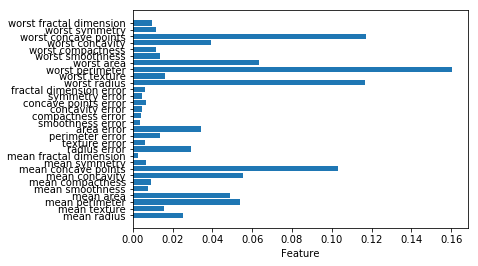

In [19]:
plot_feature_importances_cancer(forest)

- 決定木よりもはるかに多くの特徴量に対して0以上の重要度を与えている
- 決定木のときは「worst radius」特徴量に高い重要度を与えていた、ランダムフォレストでも同パラメタは同様に高いが、全体としては「worst perimeter」特徴量が最も重要になっている
- ランダムフォレストを構築する際の乱数性によってアルゴリズムは多くの可能な説明を考慮するようになるため、ランダムフォレストの結果は、個々の決定木の結果よりも広い視野でみた全体像を捉えることができる


#### デメリット
- 多くの点において決定木の欠点を補っているため、大きなデメリットはない
- 決定木よりも表現が複雑であり、決定木単独よりも深い傾向にあるため、簡潔な表現がほしい場合は決定木のほうが適している場合がある
- テキストデータなどの、非常に高次元で疎なデータに対してはうまく機能しない傾向にある
    - このようなデータに対しては線形モデルのほうが適している
- 一般的にランダムフォレストは非常に大きなデータセットに対しても機能するし、強力な計算機では複数のCPUを用いて簡単に並列化できるが、線形モデルよりも多くのメモリを消費するし、訓練も予測も遅い
    - 実行時間やメモリが重要なアプリケーションでは線形モデルを使ったほうがよい

#### メリット
- CPUコアを並行利用することができる。n_jobsパラメタ。
    - ※ コア数以上指定しても意味はない
    - n_jobs=-1を指定すると計算機の全てのコアを使うようになる

#### ポイント
- 乱数のシード(random_state)を変更すると構築されるモデルが大きく変わる可能性がある
    - 決定木の数が増えると乱数シードの選択の影響を受けにくくなる
- 調整すべき重要なパラメータは、n_estimators, max_features,とmax_depthなどの事前枝刈りパラメータ
- n_estimatorsは大きければ大きいほどよい
    - より多くの決定木の平均をとると過剰適合が低減されアンサンブルが頑健になる
    - ただし、増やすことによる利益は徐々に減少するし、メモリの量や訓練時間も増加する
- max_featuresは小さくなると過剰適合が低減する。一般にはデフォルト値をつかうとよい
    - クラス分類については、「max_features=sqrt(n_features)」回帰については「max_features=n_features」になっている
- max_featuresやmax_leaf_modesを追加すると性能があがることもある

### 勾配ブースティング回帰木(勾配ブースティングマシン)
- ランダムフォレストと同じく複数の決定木を組み合わせて強力なモデルを構築するアンサンブル手法
- 名前に「回帰」とついているが回帰にもクラス分類にも利用できる
- 勾配ブースティングでは「一つ前の決定木の誤りを次の決定木が修正して決定木を順番につくっていく」
- デフォルトでは、勾配ブースティング回帰木に乱数性はない
- 勾配ブースティングでは強力な事前枝刈りが用いられる
    - 勾配ブースティング回帰木では深さ1~5程度の非常に浅い決定木が用いられる
    - これによりモデルの占めるメモリも小さくてすみ、予測も早い
- 浅い決定木のような簡単なモデル(弱学習器: weak learner)を多数組み合わせることがポイント
- 重要なパラメータとして「learning_rate(学習率)」がある
    - 個々の決定木がそれまでの決定木の過ちをどのくらい強く補正しようとするかを制御するパラメータ
- 学習率を大きくすると、個々の決定木が強く補正を行おうとして、モデルは複雑になる
- n_estimatorsを増やし、決定木を増やすと訓練セットに対する過ちを補正する機械が増えるのでモデルは複雑になる

#### cancerデータセットをつかって適用する

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.958


- 訓練セットに対する精度が100%になっているのでおそらく過剰適合している
- 過剰適合を低減するためには深さの最大値を制限してより強力な事前枝刈りを行うか、学習率を下げる

In [25]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.972


In [26]:
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.965


#### 特徴量の重要度を可視化する

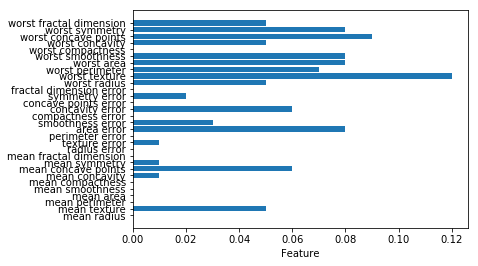

In [27]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)

- ランダムフォレストと比較するといくつかの特徴量が完全に無視されている
- 勾配ブースティングとランダムフォレストは同じようなデータを得意とするため、一般にはランダムフォレストを先に試すのがよい
    - ランダムフォレストのほうが、頑健のため
    - ランダムフォレストがうまく行ったとしても、予測時間が非常に重要な場合や、性能をより重視する場合は勾配ブースティングを試すのがよい
- xgboostパッケージのほうがscikit-learnの勾配ブースティングよりも高速な可能性もある 

#### 長所
- 教師あり学習の中でも最も強力で広く使われているモデル

#### 短所
- パラメータのチューニングに細心の注意が必要であること
- 訓練にかかる時間が長いこと
- ランダムフォレストと同様、高次元の疎なデータに対してはあまりうまく動かない

#### ポイント
- 他の決定木ベースのモデル同様特徴量のスケール変換をおこなう必要はない
- 主要なパラメータは、決定木の数を指定する「n_estimators」と個々の決定木がそれまでの決定木の誤りを補正する度合いを制御する「learning_rate」
- learning_rateを小さくすると同じ複雑さのモデルを作るにはよりたくさんの決定木が必要になる
- ランダムフォレストの場合n_estimatorsは大きければ大きいほど良かったが、勾配ブースティングの場合は複雑なモデルを許容することになり、過学習を招く
- n_estimateorを時間とメモリで決めておいて、learning_rateに対して探索を行う方法がよく用いられる
- もう一つの重要なパラメータは個々の決定木の複雑さをへらす「max_depth」で一般には勾配ブースティングでは、max_depthは非常に小さく設定される。深さが5以上になることはあまりない。